## Samsung Stock SARIMA predict

- sarima는 단기 예측에 강한 모델로 장기 예측에 적합하지 않음
- 실제 10년의 데이터로 학습하고 예측을하면 정확도와 예측이 많이 떨어짐

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm import tqdm
import matplotlib.dates as mdates

In [18]:
# 데이터 불러오기
df = pd.read_excel('../../../data/tb_stock.xlsx')
df['sc_date'] = pd.to_datetime(df['sc_date'])                                   # 'sc_date' 열을 날짜 형식으로 변환

# 2023년 6월 30일부터 1년간의 데이터 필터링
start_date = pd.to_datetime('2023-06-30')                                       # 시작 날짜를 2023년 6월 30일로 설정
end_date = start_date + pd.DateOffset(years=1)                                  # 종료 날짜를 시작 날짜로부터 1년 후로 설정
df_filtered = df[(df['sc_date'] >= start_date) & (df['sc_date'] < end_date)]    # 시작 날짜와 종료 날짜 사이의 데이터를 필터링하여 저장

# 필터링된 데이터 확인
df_filtered.head()

,sc_date,sc_ss_stock,sc_ss_per,sc_ss_pbr,sc_ss_roe,sc_ss_mc,sc_ap_stock,sc_ap_per,sc_ap_pbr,sc_ap_roe,sc_ap_mc,sc_coin
3208,2023-06-30,72200,8.96,1.25,0.139509,4.310181e+14,193.970001,30.209478,47.149749,1.56076,2.930168e+12,30477.251953
3209,2023-07-01,72200,8.96,1.25,0.139509,4.310181e+14,193.970001,30.209478,47.149749,1.56076,2.930168e+12,30590.078125
3210,2023-07-02,72200,8.96,1.25,0.139509,4.310181e+14,193.970001,30.209478,47.149749,1.56076,2.930168e+12,30620.769531
3211,2023-07-03,73000,9.06,1.26,0.139073,4.357940e+14,192.460007,29.974310,46.782708,1.56076,2.907358e+12,31156.439453
3212,2023-07-04,73000,9.06,1.26,0.139073,4.357940e+14,192.460007,29.974310,46.782708,1.56076,2.907358e+12,30777.582031


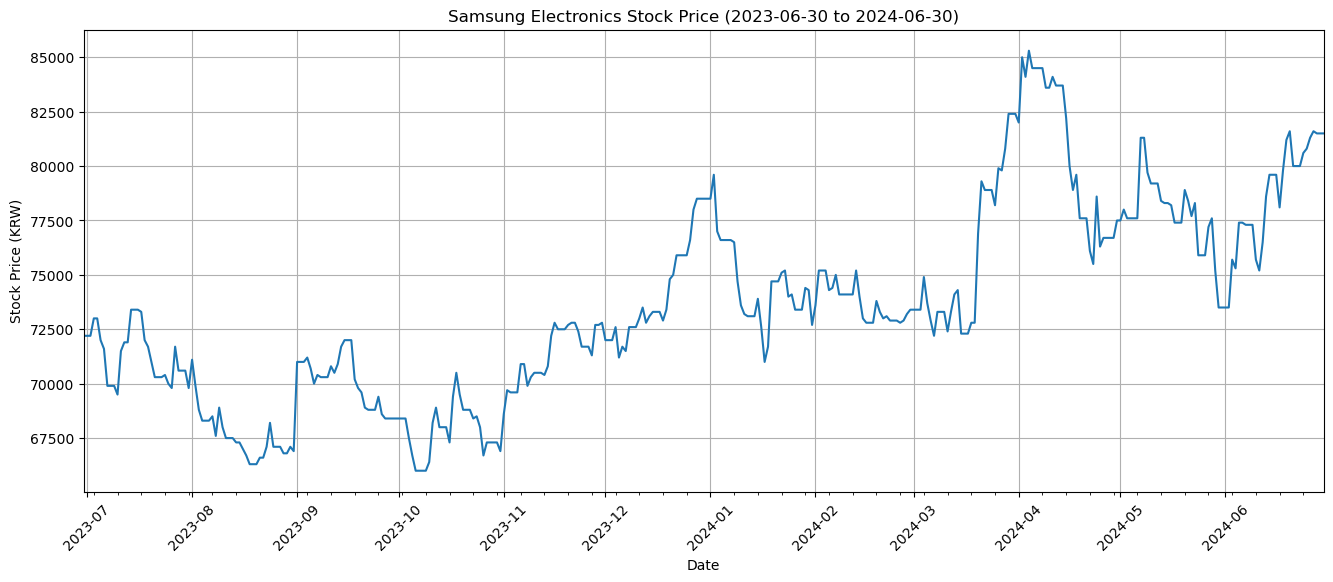

In [21]:
# 2023년 6월 30일부터 2024년 6월 30일까지의 데이터 필터링
start_date = pd.to_datetime('2023-06-30')                                       # 시작 날짜를 2023년 6월 30일로 설정
end_date = pd.to_datetime('2024-06-30')                                         # 종료 날짜를 2024년 6월 30일로 설정
df_filtered = df[(df['sc_date'] >= start_date) & (df['sc_date'] <= end_date)]   # 설정된 기간 동안의 데이터를 필터링하여 df_filtered에 저장

# 필터링된 데이터로 그래프 그리기
ax = df_filtered.set_index('sc_date')['sc_ss_stock'].plot(                      # 'sc_date'를 인덱스로 설정하고, 'sc_ss_stock' 열의 데이터를 시각화
    title="Samsung Electronics Stock Price (2023-06-30 to 2024-06-30)",         # 그래프 제목 설정
    ylabel="Stock Price (KRW)",                                                 # Y축 레이블 설정 (주가 단위: 원)
    xlabel="Date",                                                              # X축 레이블 설정 (날짜)
    figsize=(16, 6)             
)

# x축을 연도-월 형식으로 설정
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))                     # X축의 날짜 형식을 '연도-월' 형식으로 설정
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))                     # X축의 날짜 표시를 1개월 간격으로 설정

# x축의 레이블을 기울이기
plt.xticks(rotation=45)                                                         # X축 레이블을 45도 기울여서 표시

ax.grid(True)                                                                   # 그래프에 그리드를 추가하여 가독성을 높임
plt.show()  

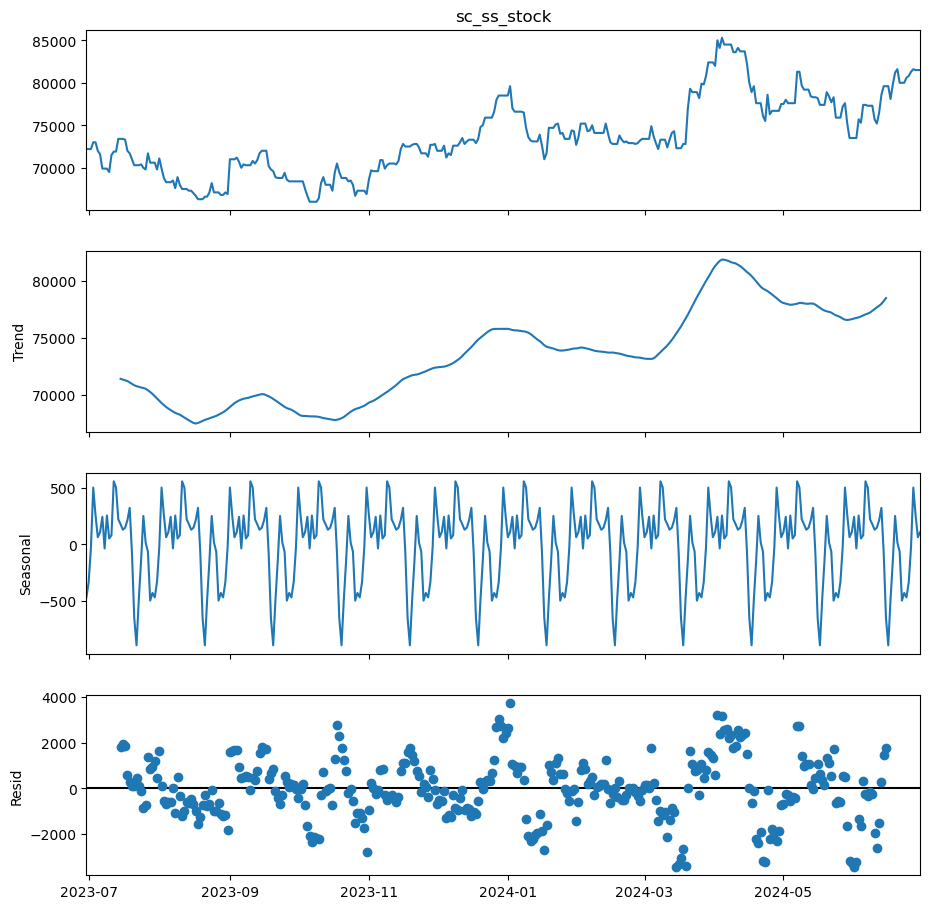

In [22]:
# 시계열 분해를 위한 데이터 준비
# 여기서 'sc_ss_stock' 열을 사용하고, 시계열 분해를 위해 날짜를 인덱스로 설정합니다.
# 필터링된 데이터를 사용하여 'sc_ss_stock' 시계열 분해
decomposition = sm.tsa.seasonal_decompose(df_filtered.set_index('sc_date')['sc_ss_stock'], 
                                          model='additive', period=30)

# 모델은 'additive'(가법)로 설정, 즉 각 구성 요소(추세, 계절성, 잔차)를 합하여 원래 시계열을 구성합니다.
# period=30은 데이터의 계절성을 30일로 설정하여 분해합니다 (월 단위로 계절성을 고려).

# 분해된 결과를 시각화
fig = decomposition.plot()      # 시계열 분해 결과를 시각화
fig.set_size_inches(10, 10)     # 시각화된 그래프의 크기를 가로 10인치, 세로 10인치로 설정
plt.show()  

### 자기상관함수(ACF) 및 부분 자기상관함수(PACF) 그래프

** 자기 상관 함수 (ACF : Autocorrelation Function) **
- 시계열 데이터에서 특정 시점의 데이터와 그 이전 시점의 데이터간 상관관계를 나타내는 함수 
- 시차(lag)에 따라 데이터 포인트 간의 상관관계를 측정하며, 시차에 따른 시계열 데이터의 패턴과 의존성 분석하는데 사용

※ ACF 값 ※
- +1 : 시차가 있는 두 시점 데이터간 완벽한 양의 상관관계가 있음을 의미 
- 0  : 시차가 있는 두 시점 데이터간 상관관계가 없음을 의미 
- -1 : 시차가 있는 두 시점 데이터간 완벽한 음의 상관관계가 있음을 의미 
- ACF : 전체 시계열에서 시차별 계산된 상관계수 플롯하는데, 특정 시차에서 얼마나 데이터가 반복되거나 계절성띄는지 확인 가능

** 부분 자기상관함수 (PACF : Partial Autocorrelation Function) **
- 특정 시차에서 다른 모든 시차 영향을 제거한 순수한 상관관계를 측정하는 함수 
- 직접적인 상관관계를 나타내며 특정 시차의 자기 상관이 다른 시차에 의해 얼마나 영향을 받는지 배제하여 분석

※ PACF의 역할 ※
- PACF는 특정 시차에서의 데이터간 직접적인 상관관계를 보여준다.

### ACF와 PACF의 활용
- 모델 선택: ACF와 PACF 플롯은 시계열 모델(예: AR, MA, ARMA, ARIMA)의 차수를 결정하는 데 사용된다. 
- 예를 들어, PACF에서 첫 번째로 유의미하게 0에 가까워지는 시차가 AR 모델의 차수를 나타낼 수 있습니다.
- 시계열 데이터 분석: ACF와 PACF 플롯을 통해 데이터의 계절성, 추세, 그리고 시차에 따른 상관관계를 분석하여, 적합한 시계열 모델을 선택할 수 있습니다.

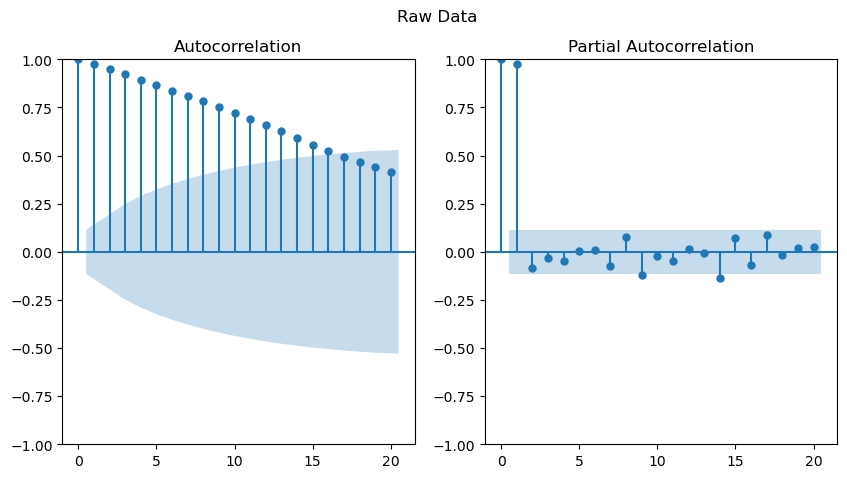

In [24]:
# 데이터를 8:2로 분할 (shuffle=False로 시계열 데이터 순서 유지)
train_data, test_data = train_test_split(df_filtered, test_size=0.2, shuffle=False)
# train_test_split을 사용하여 데이터를 8:2 비율로 훈련 데이터와 테스트 데이터로 분할합니다.
# shuffle=False로 설정하여 시계열 데이터의 순서를 유지하며, 데이터를 무작위로 섞지 않습니다.

# ACF와 PACF 플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(10, 5))       # 1행 2열의 서브플롯을 생성하여 ACF와 PACF 그래프를 동시에 표시
fig.suptitle('Raw Data')                            # 전체 그래프의 제목 설정

# ACF plot
sm.graphics.tsa.plot_acf(train_data.set_index('sc_date')['sc_ss_stock'].values.squeeze(), lags=20, ax=ax[0])
# ACF(자기상관 함수) 플롯을 생성합니다.
# train_data에서 'sc_date'를 인덱스로 설정한 후 'sc_ss_stock' 열의 값을 사용합니다.
# lags=20은 20개의 시차에 대해 자기상관을 계산합니다.
# ax=ax[0]으로 첫 번째 서브플롯에 ACF 그래프를 그립니다.

# PACF plot
sm.graphics.tsa.plot_pacf(train_data.set_index('sc_date')['sc_ss_stock'].values.squeeze(), lags=20, ax=ax[1])
# PACF(편자기상관 함수) 플롯을 생성합니다.
# 마찬가지로 train_data에서 'sc_date'를 인덱스로 설정한 후 'sc_ss_stock' 열의 값을 사용합니다.
# lags=20은 20개의 시차에 대해 편자기상관을 계산합니다.
# ax=ax[1]으로 두 번째 서브플롯에 PACF 그래프를 그립니다.

plt.show()

In [26]:
# 차분 적용
diff_train_data = train_data.copy()                                          # 원본 훈련 데이터를 변경하지 않기 위해 복사본 생성
diff_train_data['sc_ss_stock_diff'] = diff_train_data['sc_ss_stock'].diff()  # 'sc_ss_stock' 열에 차분(diff) 적용하여 새로운 열 'sc_ss_stock_diff' 생성

# 차분 후 생기는 결측치 제거
diff_train_data = diff_train_data.dropna()                                   # 차분으로 인해 첫 번째 행이 NaN이 되므로 이를 제거

# 결과 출력
star = '*'                                                                   # 출력용으로 사용되는 별 문자 (가독성을 위해 추가)
print(f'{star*15} Raw data {star*15}')                                       # 원본 데이터 표시 전 별로 구분선 출력
print(train_data['sc_ss_stock'].head())                                      # 원본 데이터('sc_ss_stock' 열)의 처음 몇 행을 출력

print(f'{star*15} Differenced data {star*15}')                               # 차분 데이터 표시 전 별로 구분선 출력
print(diff_train_data['sc_ss_stock_diff'].head())                            # 차분된 데이터('sc_ss_stock_diff' 열)의 처음 몇 행을 출력

*************** Raw data ***************
3208    72200
3209    72200
3210    72200
3211    73000
3212    73000
Name: sc_ss_stock, dtype: int64
*************** Differenced data ***************
3209       0.0
3210       0.0
3211     800.0
3212       0.0
3213   -1000.0
Name: sc_ss_stock_diff, dtype: float64


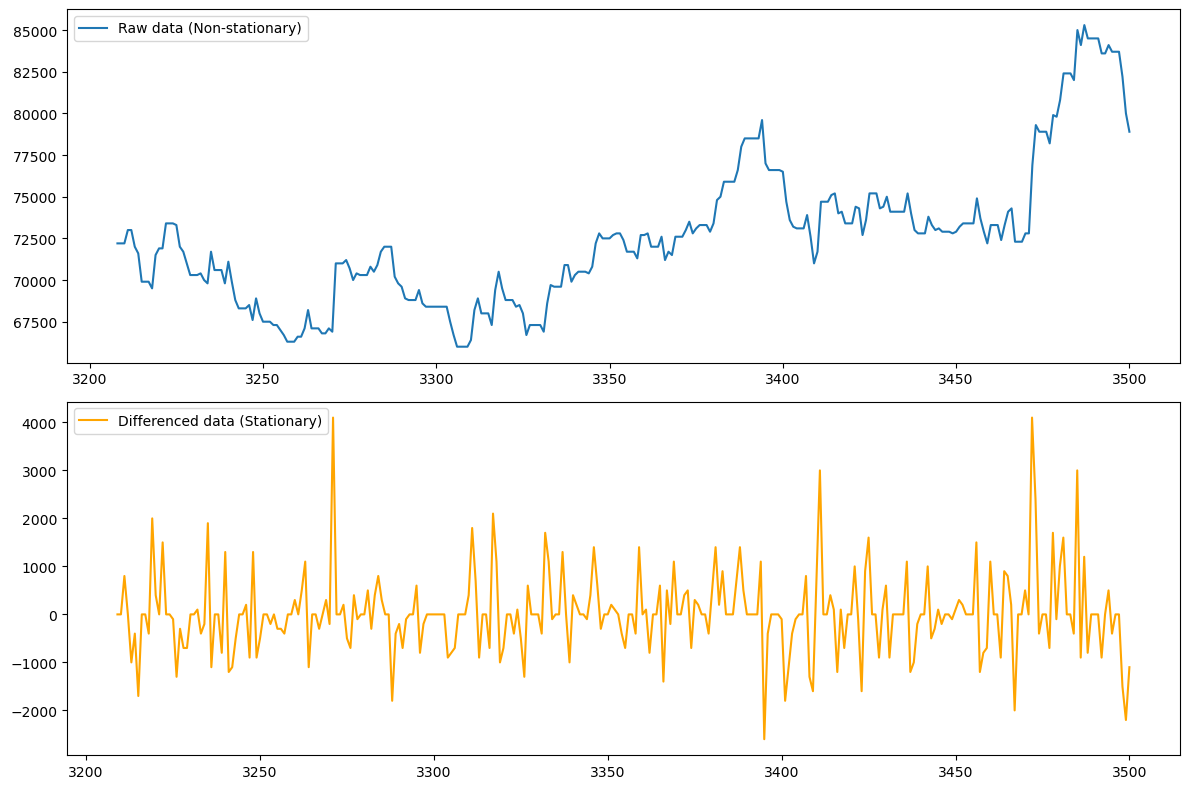

In [29]:
# 차분 시각화
fig = plt.figure(figsize=(12, 8))  
ax1 = fig.add_subplot(2, 1, 1)      # 2행 1열의 서브플롯에서 첫 번째 위치에 그래프를 추가
ax2 = fig.add_subplot(2, 1, 2)      # 2행 1열의 서브플롯에서 두 번째 위치에 그래프를 추가

# 원본 데이터 시각화
ax1.plot(train_data['sc_ss_stock'], label='Raw data (Non-stationary)')  # 원본 'sc_ss_stock' 데이터를 첫 번째 서브플롯에 플로팅
ax1.legend()                                                            # 범례를 추가하여 그래프의 데이터 설명

# 차분된 데이터 시각화
# 차분된 'sc_ss_stock_diff' 데이터를 두 번째 서브플롯에 플로팅
ax2.plot(diff_train_data['sc_ss_stock_diff'], color='orange', label='Differenced data (Stationary)')  
ax2.legend() 

# 그래프 간의 간격을 자동으로 조정하여 레이아웃을 깔끔하게 배치
plt.tight_layout()  
plt.show() 

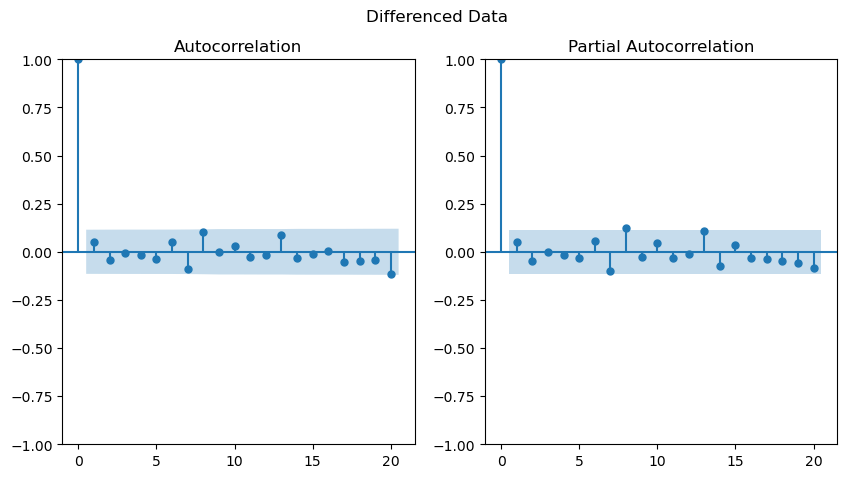

In [30]:
# ACF와 PACF 플롯 생성
fig, ax = plt.subplots(1, 2, figsize=(10, 5))   # 1행 2열의 서브플롯을 생성하여 ACF와 PACF 그래프를 동시에 표시, 전체 그래프의 크기는 가로 10인치, 세로 5인치로 설정
fig.suptitle('Differenced Data')                # 전체 그래프의 제목을 'Differenced Data'로 설정

# ACF plot
sm.graphics.tsa.plot_acf(diff_train_data['sc_ss_stock_diff'].values.squeeze(), lags=20, ax=ax[0])
# ACF(자기상관 함수) 플롯을 생성합니다.
# 차분된 데이터(diff_train_data)의 'sc_ss_stock_diff' 열을 사용하여 시계열의 자기상관을 플로팅
# values.squeeze()는 데이터가 1차원 배열로 변환되도록 합니다.
# lags=20은 20개의 시차(lag)에 대해 자기상관을 계산하고 플로팅합니다.
# ax=ax[0]으로 첫 번째 서브플롯에 ACF 그래프를 그립니다.

# PACF plot
sm.graphics.tsa.plot_pacf(diff_train_data['sc_ss_stock_diff'].values.squeeze(), lags=20, ax=ax[1])
# PACF(편자기상관 함수) 플롯을 생성합니다.
# 동일한 차분된 데이터의 'sc_ss_stock_diff' 열을 사용하여 시차에 따른 부분 상관관계를 플로팅
# lags=20은 20개의 시차에 대해 편자기상관을 계산하고 플로팅합니다.
# ax=ax[1]으로 두 번째 서브플롯에 PACF 그래프를 그립니다.

plt.show()  

### 전체 패턴 학습, 전체 예측시도

Outer Loop - Non-Seasonal Parameters: 100%|██████████| 18/18 [19:30<00:00, 65.05s/it]


Best SARIMA Model: Order (0, 0, 2), Seasonal Order (1, 1, 1, 12), AIC 56551.907572166274


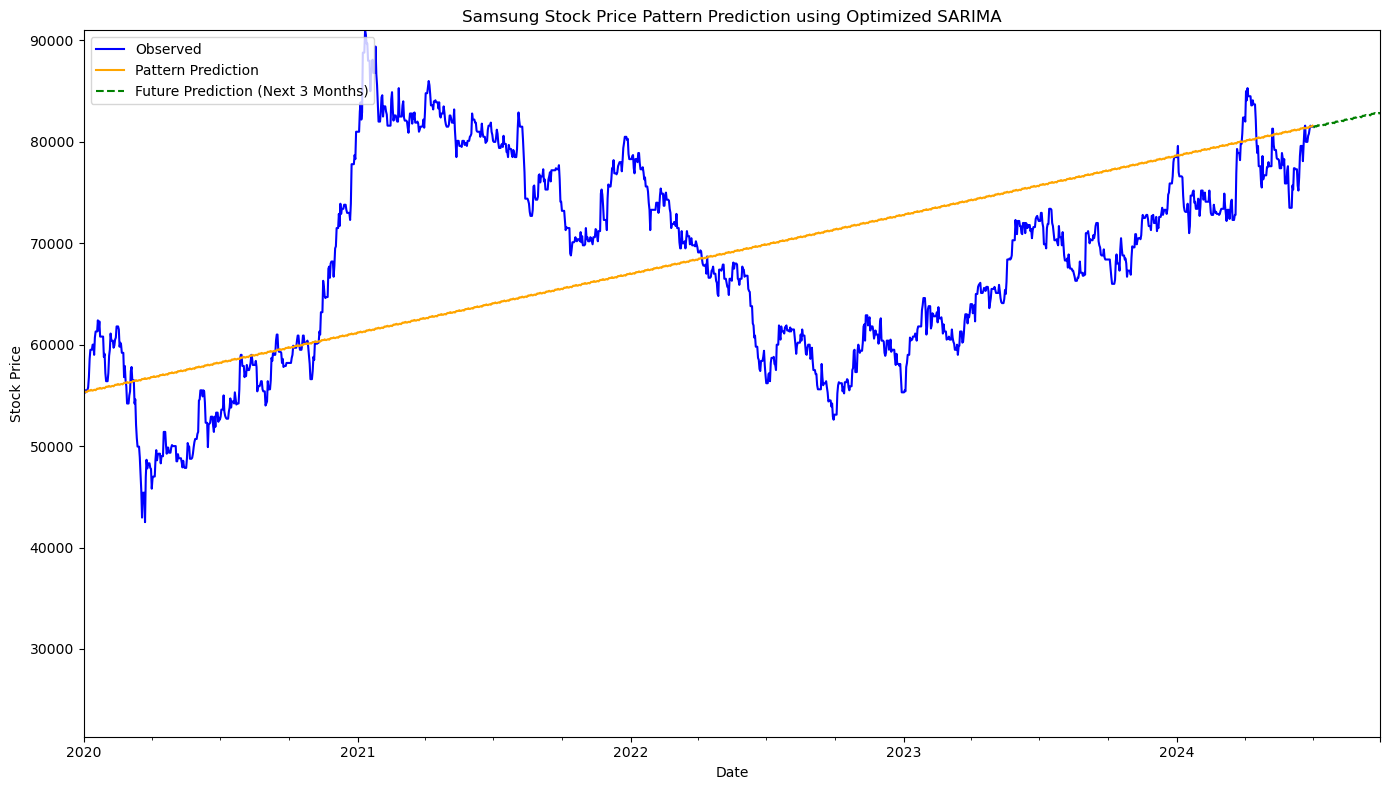

In [25]:
# import itertools  
# from statsmodels.tsa.statespace.sarimax import SARIMAX  
# import warnings  
# from tqdm import tqdm
# warnings.filterwarnings("ignore") 

# # SARIMA 모델 파라미터 탐색을 위한 설정
# p = q = range(0, 3)                     # p, q의 값을 0에서 2까지의 범위로 설정하여 가능한 조합을 탐색
# d = range(0, 2)                         # d의 값을 0에서 1까지 설정 (비계절성 차분)
# P = Q = range(0, 2)                     # P, Q의 값을 0에서 1까지 설정하여 계절성 파라미터를 탐색
# D = range(0, 2)                         # D의 값을 0에서 1까지 설정 (계절성 차분)
# m = [6, 12]                             # 계절성을 반영하기 위해 m을 6개월과 12개월로 설정 (반기 및 연간 주기)

# # 파라미터 그리드 생성 (비계절성 파라미터 및 계절성 파라미터의 모든 조합을 생성)
# pdq = list(itertools.product(p, d, q))                                              # 비계절성 파라미터 조합
# seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in itertools.product(P, D, Q, m)]    # 계절성 파라미터 조합

# # 최적의 모델을 찾기 위한 변수 초기화
# best_aic = float("inf")                 # AIC 값을 비교하기 위해 초기값을 무한대로 설정
# best_order = None                       # 최적의 비계절성 파라미터 (p, d, q) 저장 변수
# best_seasonal_order = None              # 최적의 계절성 파라미터 (P, D, Q, m) 저장 변수
# best_model = None                       # 최적의 SARIMA 모델 저장 변수

# # tqdm을 사용하여 파라미터 탐색의 진행 상황을 표시
# for param in tqdm(pdq, desc="Outer Loop - Non-Seasonal Parameters"):
#     for seasonal_param in tqdm(seasonal_pdq, desc="Inner Loop - Seasonal Parameters", leave=False):
#         try:
#             # SARIMA 모델 생성 및 학습
#             model = SARIMAX(df_filtered['sc_ss_stock_diff'].dropna(),               # 차분된 데이터 사용
#                             order=param,                                            # 현재 비계절성 파라미터 조합
#                             seasonal_order=seasonal_param,                          # 현재 계절성 파라미터 조합
#                             enforce_stationarity=False,                             # 비정상성을 허용
#                             enforce_invertibility=False)                            # 비가역성을 허용
#             model_fit = model.fit(disp=False)                                       # 모델을 학습하고 출력은 생략
#             aic = model_fit.aic                                                     # AIC 값 계산
            
#             # 현재 모델의 AIC 값이 더 낮다면 최적의 모델로 갱신
#             if aic < best_aic:
#                 best_aic = aic                                                      # 최적의 AIC 값 갱신
#                 best_order = param                                                  # 최적의 비계절성 파라미터 갱신
#                 best_seasonal_order = seasonal_param                                # 최적의 계절성 파라미터 갱신
#                 best_model = model_fit                                              # 최적의 모델 갱신
#         except Exception as e:
#             continue                                                                # 오류가 발생해도 루프를 계속 진행

# # 최적의 SARIMA 모델과 그 파라미터를 출력
# print(f"Best SARIMA Model: Order {best_order}, Seasonal Order {best_seasonal_order}, AIC {best_aic}")

# # 최적의 모델을 사용하여 과거 데이터 전체에 대한 예측 수행
# num_periods = len(df_filtered)                                                      # 예측할 기간의 길이
# pred = best_model.get_forecast(steps=num_periods)                                   # 주어진 기간 동안의 예측 수행
# pred_val = pred.predicted_mean.cumsum() + df_filtered['sc_ss_stock'].iloc[0]        # 누적합을 통해 차분을 복원하고, 실제 값으로 변환

# # 최적의 모델을 사용하여 미래 3개월 예측 수행
# future_steps = 3 * 30                                                                                   # 3개월 동안의 예측 (대략 90일)
# future_pred = best_model.get_forecast(steps=future_steps)                                               # 미래 예측 수행
# future_pred_val = future_pred.predicted_mean.cumsum() + df_filtered['sc_ss_stock'].iloc[-1]             # 누적합을 통해 차분을 복원하고, 실제 값으로 변환
# future_pred_dates = pd.date_range(start=df_filtered.index[-1], periods=future_steps + 1, freq='D')[1:]  # 예측된 미래 날짜 생성

# # 예측 결과를 시각화
# fig, ax = plt.subplots(figsize=(14, 8))  

# # 실제 데이터와 과거에 대한 예측 결과 시각화
# df_filtered['sc_ss_stock'].plot(ax=ax, label='Observed', color='blue')              # 실제 데이터를 파란색으로 플롯
# ax.plot(df_filtered.index, pred_val, label='Pattern Prediction', color='orange')    # 과거 예측 데이터를 주황색으로 플롯

# # 미래에 대한 예측 결과 시각화
# ax.plot(future_pred_dates, future_pred_val, label='Future Prediction (Next 3 Months)', color='green', linestyle='--')  # 미래 예측 데이터를 초록색 점선으로 플롯

# # 그래프의 X축 범위를 2020년부터 설정하여 데이터의 특정 기간만 표시
# ax.set_xlim([pd.Timestamp('2020-01-01'), future_pred_dates.max()])                  # X축 범위를 2020년부터 미래 예측 끝까지 설정

# # 그래프의 Y축 범위 설정
# ax.set_ylim([min(df_filtered['sc_ss_stock'].min(), future_pred_val.min()),          # Y축 최소값 설정
#             max(df_filtered['sc_ss_stock'].max(), future_pred_val.max())])          # Y축 최대값 설정

# # 그래프 제목 및 레이블 설정
# ax.set_title('Samsung Stock Price Pattern Prediction using Optimized SARIMA')       
# ax.set_xlabel('Date')                                                              
# ax.set_ylabel('Stock Price')                                                       
# ax.legend(loc='upper left')  

# # 레이아웃 조정 및 그래프 출력
# plt.tight_layout()                  # 그래프 레이아웃 조정 (요소들이 겹치지 않도록)
# plt.show()                          # 그래프를 화면에 출력

# 여기서부터 더 자세한 SARIMA 

- 최근 [ 설정일자 ] 데이터를 학습해서 [ 설정 미래 기간 ]을 예측, 
- [ 미래기간 ] 포함, [ 설정 최근일자 ]로 다시 다음 예측을 진행하는걸로 시도

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import itertools
from tqdm import tqdm
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose                       # 계절성 분해 함수
from pandas.plotting import autocorrelation_plot
import warnings
import pickle

warnings.filterwarnings("ignore") # 경고 무시

### 전체 데이터

In [19]:
# 데이터 불러오기
df = pd.read_excel('../../../data/tb_stock.xlsx')  
df['sc_date'] = pd.to_datetime(df['sc_date'])                       # 날짜 데이터 타입 변환

# 2014년 9월 14일부터 2024년 6월 30일까지의 데이터 필터링
start_date = pd.to_datetime('2014-09-14')                           # 시작 날짜
end_date = pd.to_datetime('2024-06-30')                             # 종료 날짜

# 날짜 필터링
df_filtered = df[(df['sc_date'] >= start_date) & (df['sc_date'] <= end_date)].copy() 

# 날짜를 인덱스로 설정 및 인덱스 리셋
df_filtered.set_index('sc_date', inplace=True)                      # sc_date를 인덱스로 설정
df_filtered = df_filtered.asfreq('D').fillna(method='ffill')        # 채워지지 않은 날짜는 이전 값으로 채움

### 4년치로 줄여보기

In [4]:
# 데이터 불러오기
df = pd.read_excel('../../../data/tb_stock.xlsx')  
df['sc_date'] = pd.to_datetime(df['sc_date'])                       # 날짜 데이터 타입 변환

# 2014년 9월 14일부터 2024년 6월 30일까지의 데이터 필터링
start_date = pd.to_datetime('2021-01-01')                           # 시작 날짜
end_date = pd.to_datetime('2024-06-30')                             # 종료 날짜

# 날짜 필터링
df_filtered = df[(df['sc_date'] >= start_date) & (df['sc_date'] <= end_date)].copy() 

# 날짜를 인덱스로 설정 및 인덱스 리셋
df_filtered.set_index('sc_date', inplace=True)                      # sc_date를 인덱스로 설정
df_filtered = df_filtered.asfreq('D').fillna(method='ffill')        # 채워지지 않은 날짜는 이전 값으로 채움

### 10년치 데이터로 계절성 주기 확인

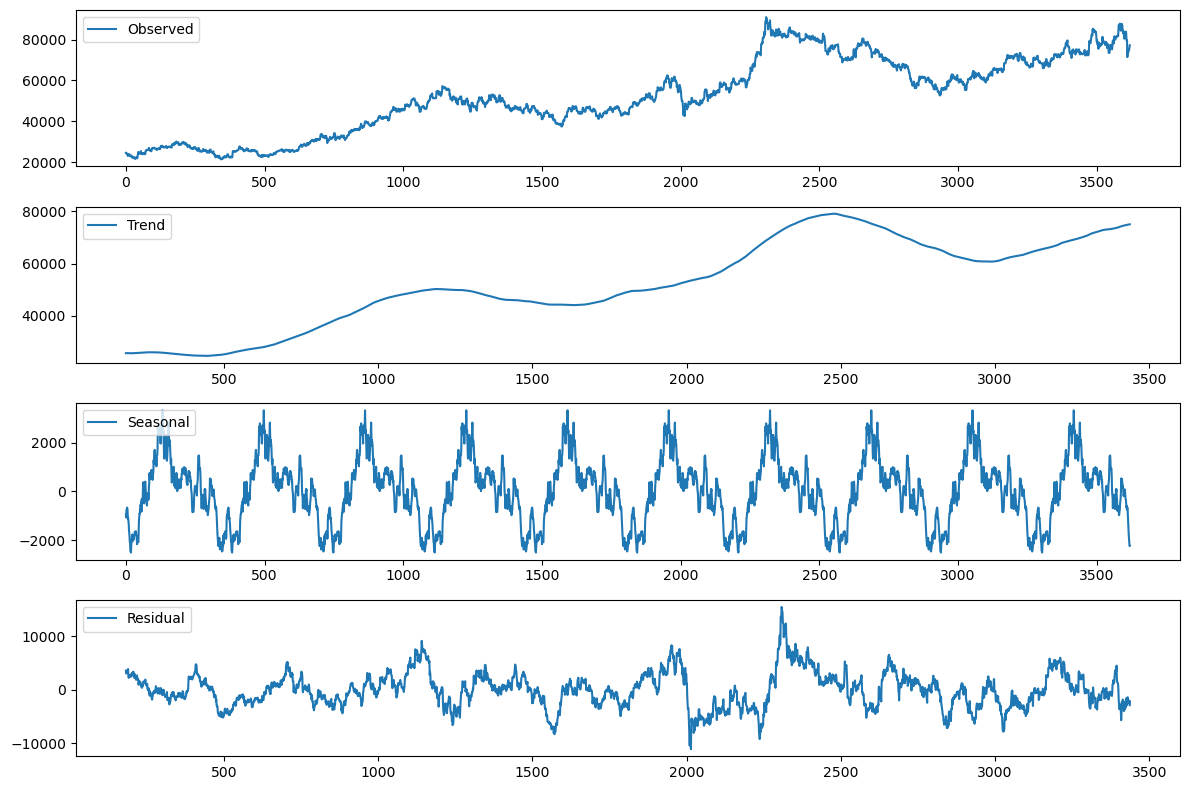

In [37]:
# 계절성 확인을 위해 시계열 데이터를 추출
time_series = df['sc_ss_stock']                                               # 'sc_ss_stock' 열을 시계열 데이터로 사용
decomposition = seasonal_decompose(time_series, model='additive', period=365) # 계절성 주기는 365일로 설정

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)                                                              # 4행 1열 중 1행에 그래프 출력
plt.plot(decomposition.observed, label='Observed')                            # 관측값
plt.legend(loc='upper left')                                                  # 범례 위치 설정
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')                                  # 추세
plt.legend(loc='upper left')                                                  # 범례 위치 설정
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')                            # 계절성
plt.legend(loc='upper left')                                                  # 범례 위치 설정
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')                               # 잔차
plt.legend(loc='upper left')                                                  # 범례 위치 설정
plt.tight_layout()

plt.show()

#### 2021년부터 계절성 주기 확인

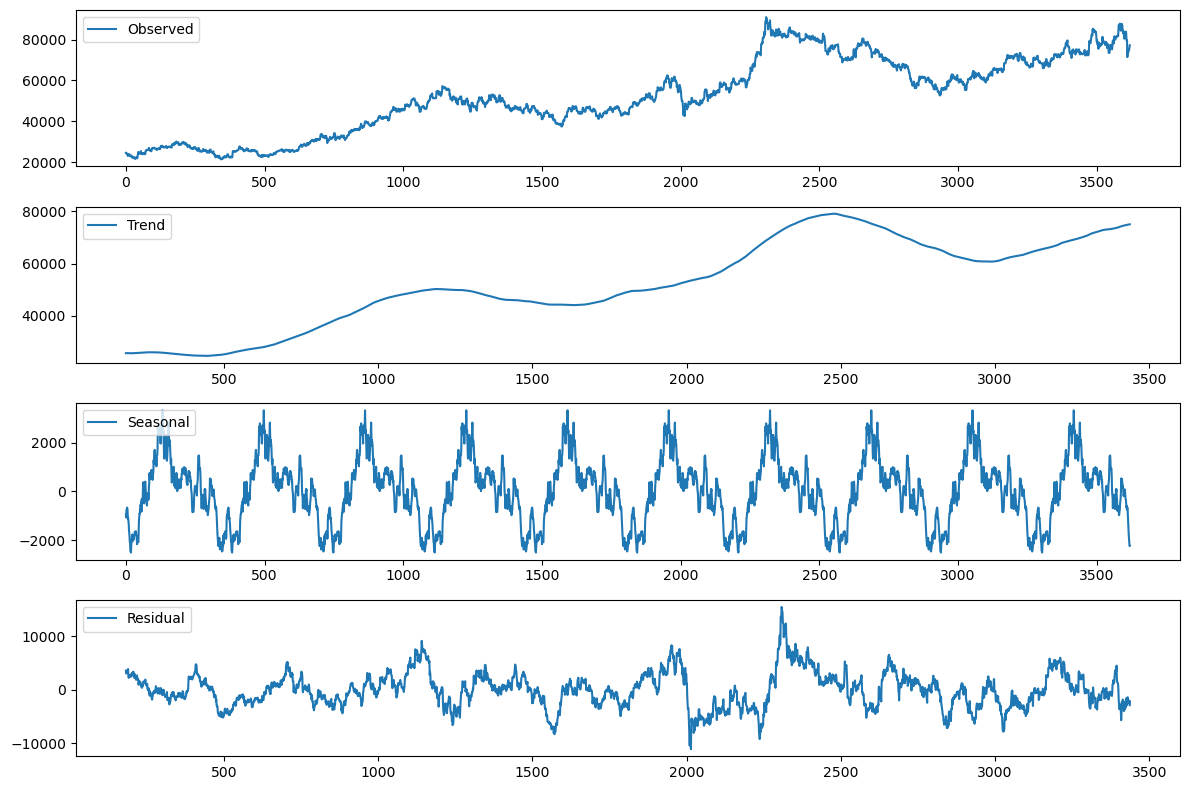

In [162]:
# 계절성 확인을 위해 시계열 데이터를 추출
time_series = df['sc_ss_stock']
decomposition = seasonal_decompose(time_series, model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')                              # 관측값
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')                                    # 추세
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')                              # 계절성
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')                                 # 잔차
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

### 10년치 자기상관도 확인
- 14년도 부터 2014년도 6월 30일까지 전체 데이터로 측정

### 자기 상관도? 
- 시계열 데이터의 패턴 파악을 위해 사용
- 시계열 모델의 적합성을 평가하기 위해 모델의 잔차 (residuals)가 백색잡음 (white noise)인지 확인할 수 있다. 잔차의 자기 상관도가 0에 가까운 경우 , 모델이 데이터를 잘 설명하고 있음을 의미한다.
- 시계열 데이터에서 특정 시점과 이전 시점 간의 상관관계를 시각적으로 분석하는 도구로써, 데이터의 패턴을 이해하고 적절한 시계열 모델을 선택하거나 성능을 평가하는데 사용할 수 있다.

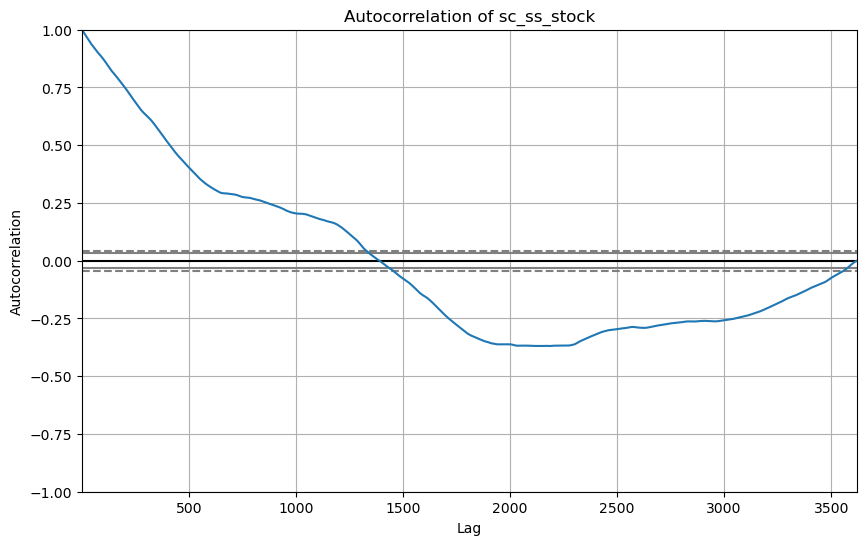

In [38]:
plt.figure(figsize=(10, 6))
autocorrelation_plot(time_series)                # 자기상관도 플롯
plt.title("Autocorrelation of sc_ss_stock")  
plt.show()

#### 21년도부터 데이터로 자기상관도 플롯 확인하기 

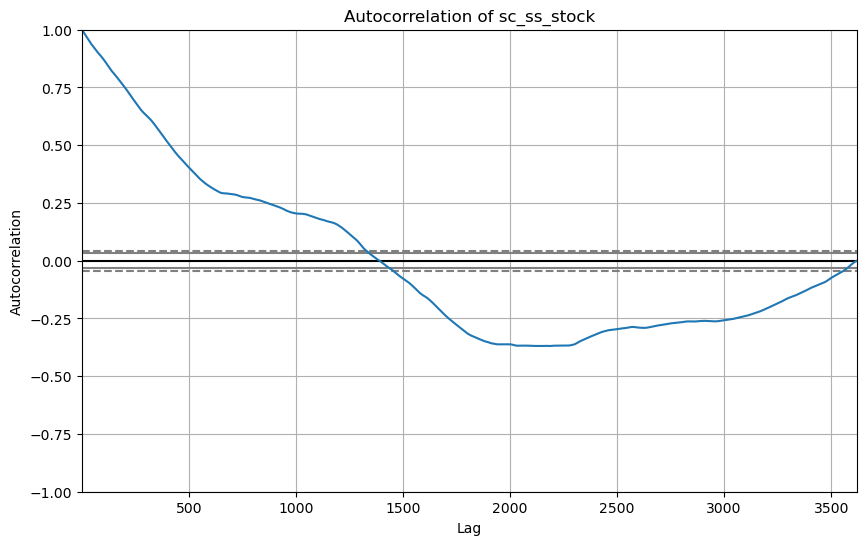

In [163]:
plt.figure(figsize=(10, 6))
autocorrelation_plot(time_series)               # 자기상관도 플롯
plt.title("Autocorrelation of sc_ss_stock")
plt.show()

### SARIMA 모델 최적 파라미터 찾는 과정 코드
- 같은 코드로 돌리고 같은 값을 주었더라도, 최적값이 동일하지 않을 수 있음

- 비계절성 파라미터 (p, d, q)
    1. p (Autoregressive order) : 시계열의 자기 회귀(AR) 부분의 차수. 

        이전 시점의 값이 현재 시점 값에 영향을 미치는 정도를 결정합니다. 'p'값이 클수록 더 많은 이전 시점의 값이 고려됩니다.

    2. d (Differencing order) : 시계열 데이터의 차분 횟수. 

        시계열 데이터의 정상성을 만들기 위해 몇번의 차분을 해야하는지 나타낸다. 'd'가 1이라면 1차 차분을 취해 정상성을 유도합니다.

    3. q (Moving Average order) : 시계열의 이동평균 (MA) 부분의 차수. 

        과거 예측 오차가 현재 시점의 값에 영향을 미치는 정도를 결정합니다. 'q' 값이 클수록 더 많은 이전의 예측 오차들이 고려됩니다.

- 계절성 파라미터 (P, D, Q, m)
    1. P (Seasonal autoregressive order) : 계절성 자기 회귀 부분의 차수. 

        계절주기에서 이전주기의 값이 현재 값에 미치는 영향을 모델링합니다. 'P' 값이 클수록 계절 주기 내의 더 이전 시점들이 고려됩니다.

    2. D (Seasonal differencing order) : 계절성 차분 횟수. 

        계절성을 제거하기 위해 몇번의 계절 차분을 해야하는지 나타냅니다. 'D'가 1이라면 계절 주기에 해당하는 주기에서 1차 차분을 취합니다.

    3. Q (Seasonal moving average order) : 계절성 이동평균 부분의 차수. 

        계절 주기 내에서 과거의 예측 오차가 현재 값에 미치는 영향을 모델링합니다. 'Q'값이 클수록 계절 주기 내의 더 많은 이전 예측 오차들이 고려됩니다. 

    4. m (Seasonal period) : 계절 주기의 길이. 
    
        데이터가 일자인지, 월자 데이터인지에 따라 다름
        - 일별 데이터 : 계절주기가 1년이라 (365일)이라면 m은 365가 되고 주단위로 고려하고자 하면 7로 설정하면 됩니다.
        - 월별 데이터 : 계절주기가 1년이라면 12가 됩니다.
        - 분기별 데이터 : 1년 4분기 계절주기라면 m은 4가 됩니다.
        - 주별 데이터 : 데이터가 주별 데이터이고 1년이 52주 라면 m은 52가 됩니다. 

따라서 계절성 주기 중, m의 데이터 값에 따라 달라지는 주기가 중요하며 올바른 m값을 설정해야 SARIMA 모델이 계절성을 정확하게 파악하여 예측을 수행하는데 필수적입니다.

In [5]:
# # SARIMA 모델 파라미터 탐색
# p = q = range(0, 3)            # p, q의 범위를 0에서 2까지 확장
# d = range(0, 2)                # d의 범위를 0에서 1까지 설정
# P = Q = range(0, 2)            # P, Q의 범위를 0에서 1까지 설정
# D = range(0, 2)                # D의 범위를 0에서 1까지 설정
# m = [7, 14]                    # 7일, 14일 계절성을 반영하기 위해 m=7, 14를 시도

# # 파라미터 그리드 생성 (p, d, q) x (P, D, Q, m) 조합 생성
# pdq = list(itertools.product(p, d, q)) 

# # 계절성 주기 m을 고려하여 SARIMA 파라미터 그리드 생성
# seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in itertools.product(P, D, Q, m)]

In [5]:
# best_aic = float("inf")        # AIC 값을 비교하기 위해 초기값을 무한대로 설정 (모든 AIC 값보다 높도록)
# best_order = None              # 최적의 (p, d, q) 값을 저장할 변수, 초기값은 None으로 설정
# best_seasonal_order = None     # 최적의 (P, D, Q, m) 계절성 파라미터 값을 저장할 변수, 초기값은 None으로 설정
# best_model = None              # 최적의 SARIMA 모델을 저장할 변수, 초기값은 None으로 설정

# # 비계절성 파라미터 조합을 순회하는 외부 루프 (p, d, q 조합을 탐색)
# for param in tqdm(pdq, desc="Outer Loop - Non-Seasonal Parameters"):
#     for seasonal_param in tqdm(seasonal_pdq, desc="Inner Loop - Seasonal Parameters", leave=False):
#         try:
#             # SARIMAX 모델을 생성, 현재 비계절성 파라미터와 계절성 파라미터를 사용
#             model = SARIMAX(df_filtered['sc_ss_stock'].dropna(),
#                             order=param,                            # 현재 비계절성 (p, d, q) 조합
#                             seasonal_order=seasonal_param,          # 현재 계절성 (P, D, Q, m) 조합
#                             enforce_stationarity=False,             # 모델이 자동으로 비정상성을 허용하도록 설정
#                             enforce_invertibility=False)            # 모델이 자동으로 비가역성을 허용하도록 설정
            
#             model_fit = model.fit(disp=False)                       # 모델을 학습시키고 적합, 출력을 표시하지 않도록 설정하여 학습
#             aic = model_fit.aic                                     # 모델의 AIC (Akaike Information Criterion) 값을 계산
            
#             if aic < best_aic:                                      # 현재 모델의 AIC 값이 이전 최저 AIC 값보다 작으면
#                 best_aic = aic                                      # 최저 AIC 값을 업데이트
#                 best_order = param                                  # 최적의 (p, d, q) 조합을 업데이트
#                 best_seasonal_order = seasonal_param                # 최적의 (P, D, Q, m) 조합을 업데이트
#                 best_model = model_fit                              # 최적의 모델을 업데이트
        
#         # 예외가 발생해도 루프 계속 진행 처리 (예외 발생 시 무시하고 다음 루프로 이동)
#         except Exception as e:
#             continue

# # 최적의 SARIMA 모델 파라미터와 AIC 값을 출력
# print(f"Best SARIMA Model: Order {best_order}, Seasonal Order {best_seasonal_order}, AIC {best_aic}")

Outer Loop - Non-Seasonal Parameters: 100%|██████████| 18/18 [07:21<00:00, 24.55s/it]

Best SARIMA Model: Order (2, 1, 2), Seasonal Order (1, 1, 1, 14), AIC 20365.114892385573


### 이전에 찾았던 Best 파라미터 값으로 학습

In [6]:
# 최적의 SARIMA 모델 파라미터 설정 (시도하면서 가장 괜찮은 파라미터값)
best_order = (1, 1, 2)                              # 비계절성 파라미터 (p, d, q) 설정: (1, 1, 2)
best_seasonal_order = (1, 1, 2, 12)                 # 계절성 파라미터 (P, D, Q, m) 설정: (1, 1, 2, 12)

# SARIMA 모델 학습
model = SARIMAX(df_filtered['sc_ss_stock'],         # 학습에 사용할 타겟 변수 ('sc_ss_stock') 지정 
                order=best_order,                   # 비계절성 파라미터 적용
                seasonal_order=best_seasonal_order, # 계절성 파라미터 적용
                enforce_stationarity=False,         # 비정상성을 허용 (모델이 데이터를 자동으로 비정상적으로 만들지 않음)
                enforce_invertibility=False)        # 비가역성을 허용 (모델이 데이터를 자동으로 가역적으로 만들지 않음)

# 모델을 피팅 (학습)함. 학습 중 출력은 생략(disp=False)
model_fit = model.fit(disp=False)

# 모델 요약 정보 출력 (파라미터, AIC, BIC 등)
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        sc_ss_stock   No. Observations:                 1277
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood              -10044.078
Date:                            Wed, 28 Aug 2024   AIC                          20102.155
Time:                                    12:34:12   BIC                          20137.999
Sample:                                01-01-2021   HQIC                         20115.637
                                     - 06-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6476      0.091      7.120      0.000       0.469       0.826
ma.L1         -0.6506      0.095   

In [7]:
# 최근 60일 데이터로 14일씩 예측 (1개월치)
steps_ahead =14                                             # 14일씩 예측
total_future_steps = 1 * 30                                 # 1개월 예측
future_pred_val = []                                        # 미래 예측값을 저장할 리스트
last_observed = df_filtered['sc_ss_stock'].iloc[-60:]       # 최근 60일 데이터로 예측 시작

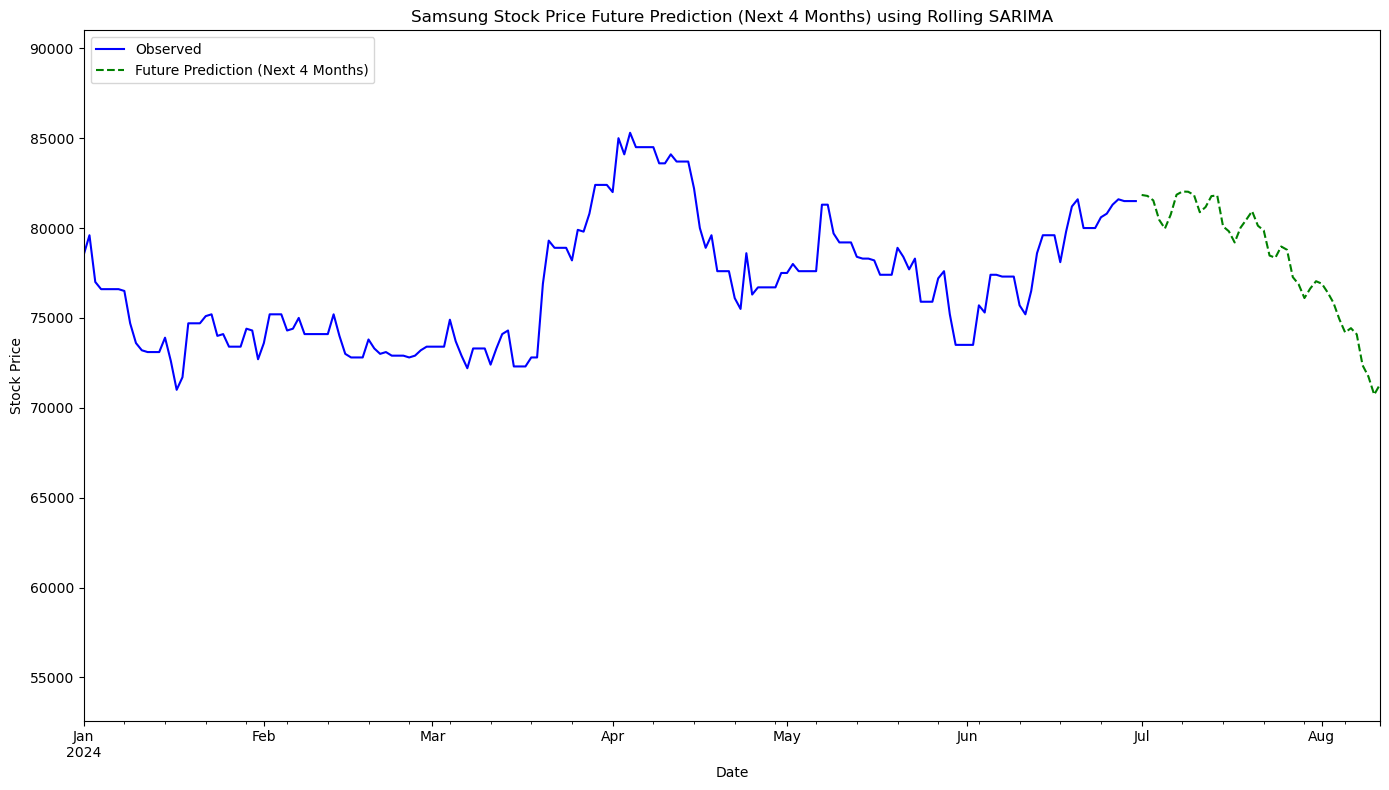

In [8]:
for _ in range(0, total_future_steps, steps_ahead):

    # SARIMAX 모델을 생성하여 학습, 최근 60일의 데이터를 사용
    model = SARIMAX(last_observed.diff().dropna(),          # 최근 60일 데이터 사용 (차분하여 추세를 제거)
                    order=best_order,                       # 이전에 찾은 최적의 비계절성 (p, d, q) 파라미터를 사용
                    seasonal_order=best_seasonal_order,     # 이전에 찾은 최적의 계절성 (P, D, Q, m) 파라미터를 사용
                    enforce_stationarity=False,             # 비정상성을 허용하도록 설정
                    enforce_invertibility=False)            # 비가역성을 허용하도록 설정
    model_fit = model.fit(disp=False)                       # 모델을 학습시키고, 학습 중 출력은 생략
    
    # 14일 예측
    pred = model_fit.get_forecast(steps=steps_ahead)                        # steps_ahead만큼 미래 데이터를 예측
    pred_mean = pred.predicted_mean.cumsum() + last_observed.iloc[-1]       # 예측 결과를 원래 스케일로 변환 (cumsum을 통해 누적합 계산)
    future_pred_val.extend(pred_mean)                                       # 예측 결과를 미래 예측 리스트에 추가
    
    # 예측된 14일 데이터를 최근 60일 데이터에 추가
    last_observed = pd.concat([last_observed, pred_mean]).iloc[-60:]        # 최근 60일 데이터를 유지하며 새로운 데이터를 추가

# 미래 예측 날짜 생성
future_pred_dates = pd.date_range(start=df_filtered.index[-1], periods=len(future_pred_val) + 1, freq='D')[1:]

# 전체 예측 결과 시각화
fig, ax = plt.subplots(figsize=(14, 8))

# 실제 데이터와 패턴 예측 시각화
df_filtered['sc_ss_stock'].plot(ax=ax, label='Observed', color='blue')

# 미래 1개월 예측 시각화 (초록색 선)
ax.plot(future_pred_dates, future_pred_val, label='Future Prediction (Next 1 Months)', color='green', linestyle='--')

# 그래프의 X축 범위를 2024년부터 시작하도록 설정 / 예측된 마지막 날짜까지 설정
ax.set_xlim([pd.Timestamp('2024-01-01'), future_pred_dates.max()])

# Y축 범위 설정
ax.set_ylim([min(df_filtered['sc_ss_stock'].min(), min(future_pred_val)),   # Y축 최소값을 실제 데이터와 예측 데이터 중 최소값으로 설정
            max(df_filtered['sc_ss_stock'].max(), max(future_pred_val))])   # Y축 최대값을 실제 데이터와 예측 데이터 중 최대값으로 설정

# 그래프 제목 및 레이블
ax.set_title('Samsung Stock Price Future Prediction (Next 1 Months) using Rolling SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.legend(loc='upper left')

# 레이아웃 조정 및 그래프 출력
plt.tight_layout()              # 레이아웃을 조정하여 그래프 요소들이 겹치지 않도록 함
plt.show()                      # 그래프를 화면에 출력

### 성능평가

In [9]:
# 데이터의 차분을 계산하여 'sc_ss_stock_diff' 열에 저장
df_filtered['sc_ss_stock_diff'] = df_filtered['sc_ss_stock'].diff() # 주가 데이터의 1차 차분을 계산하여 추세를 제거 (이동 평균을 사용하여 안정화)
df_filtered['sc_ss_stock_diff']                                     # 차분된 데이터를 확인

sc_date
2021-01-01       NaN
2021-01-02       0.0
2021-01-03       0.0
2021-01-04    2000.0
2021-01-05     900.0
               ...  
2024-06-26     500.0
2024-06-27     300.0
2024-06-28    -100.0
2024-06-29       0.0
2024-06-30       0.0
Freq: D, Name: sc_ss_stock_diff, Length: 1277, dtype: float64

In [10]:
# SARIMA 모델 평가를 위한 코드
# 훈련 데이터와 테스트 데이터를 분리하기 위해 데이터셋의 80%를 훈련 데이터로 사용
train_size = int(len(df_filtered) * 0.8)                                                                    # 전체 데이터의 80%를 훈련 데이터로 사용
train, test = df_filtered['sc_ss_stock_diff'][:train_size], df_filtered['sc_ss_stock_diff'][train_size:]    # 훈련 데이터와 테스트 데이터로 분할

# 최적의 SARIMA 모델을 사용하여 훈련 데이터에 대한 모델 학습
best_model = SARIMAX(train.dropna(),                            # 결측치를 제거한 훈련 데이터를 사용하여 모델 학습
                     order=best_order,                          # 이전에 찾은 최적의 비계절성 (p, d, q) 파라미터를 사용
                     seasonal_order=best_seasonal_order,        # 이전에 찾은 최적의 계절성 (P, D, Q, m) 파라미터를 사용
                     enforce_stationarity=False,                # 비정상성을 허용
                     enforce_invertibility=False)               # 비가역성을 허용
best_model_fit = best_model.fit(disp=False)                     # 모델을 학습시키고, 학습 중 출력은 생략

# 훈련 데이터에 대한 예측
train_predictions = best_model_fit.predict(start=0, end=len(train)-1, dynamic=False)                    # 훈련 데이터의 예측값 생성
train_predictions_cumsum = train_predictions.cumsum() + df_filtered['sc_ss_stock'].iloc[0]              # 차분을 복원하여 실제 데이터와 비교 가능하게 함

# 테스트 데이터에 대한 예측
test_predictions = best_model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)  # 테스트 데이터에 대한 예측 수행
test_predictions_cumsum = test_predictions.cumsum() + df_filtered['sc_ss_stock'].iloc[train_size - 1]   # 차분을 복원하여 실제 데이터와 비교 가능하게 함

# 훈련 데이터에 대한 성능 평가
train_mae = mean_absolute_error(df_filtered['sc_ss_stock'][:train_size], train_predictions_cumsum)      # 훈련 데이터에 대한 MAE 계산
train_mse = mean_squared_error(df_filtered['sc_ss_stock'][:train_size], train_predictions_cumsum)       # 훈련 데이터에 대한 MSE 계산
train_rmse = np.sqrt(train_mse)                                                                         # 훈련 데이터에 대한 RMSE 계산
train_r2 = r2_score(df_filtered['sc_ss_stock'][:train_size], train_predictions_cumsum)                  # 훈련 데이터에 대한 R² 계산

# 훈련 데이터의 성능 평가 지표 출력
print(f'Training MAE: {train_mae}')
print(f'Training MSE: {train_mse}')
print(f'Training RMSE: {train_rmse}')
print(f'Training R²: {train_r2}')

# 테스트 데이터에 대한 성능 평가
test_mae = mean_absolute_error(df_filtered['sc_ss_stock'][train_size:], test_predictions_cumsum)        # 테스트 데이터에 대한 MAE 계산
test_mse = mean_squared_error(df_filtered['sc_ss_stock'][train_size:], test_predictions_cumsum)         # 테스트 데이터에 대한 MSE 계산
test_rmse = np.sqrt(test_mse)                                                                           # 테스트 데이터에 대한 RMSE 계산
test_r2 = r2_score(df_filtered['sc_ss_stock'][train_size:], test_predictions_cumsum)                    # 테스트 데이터에 대한 R² 계산

# 테스트 데이터의 성능 평가 지표 출력
print(f'Test MAE: {test_mae}')
print(f'Test MSE: {test_mse}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R²: {test_r2}')

# SARIMA 모델의 요약 정보 출력 (모델의 전체적인 요약 정보 확인)
print(best_model_fit.summary())

# 모델이 과소적합인지 과대적합인지 판단
if train_rmse > test_rmse:
    print("모델이 과소적합 상태일 수 있습니다. 훈련 데이터의 오류가 테스트 데이터보다 큽니다.")
elif train_rmse < test_rmse:
    print("모델이 과대적합 상태일 수 있습니다. 훈련 데이터의 오류가 테스트 데이터보다 작습니다.")
else:
    print("모델이 적절하게 적합된 것 같습니다. 훈련 데이터와 테스트 데이터에서 비슷한 성능을 보입니다.")

Training MAE: 5392.136437313063
Training MSE: 42998299.79615419
Training RMSE: 6557.308883692623
Training R²: 0.42800962228455597
Test MAE: 2077.8890221753927
Test MSE: 8199432.2025247365
Test RMSE: 2863.4650691993324
Test R²: 0.47994122544963136
                                     SARIMAX Results                                      
Dep. Variable:                   sc_ss_stock_diff   No. Observations:                 1020
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -8058.640
Date:                            Wed, 28 Aug 2024   AIC                          16131.280
Time:                                    12:34:49   BIC                          16165.493
Sample:                                01-02-2021   HQIC                         16144.296
                                     - 10-18-2023                                         
Covariance Type:                              opg                                         
                 coef    

MAE: 2077.8890221753927
MSE: 8199432.2025247365
RMSE: 2863.4650691993324
R²: 0.47994122544963136


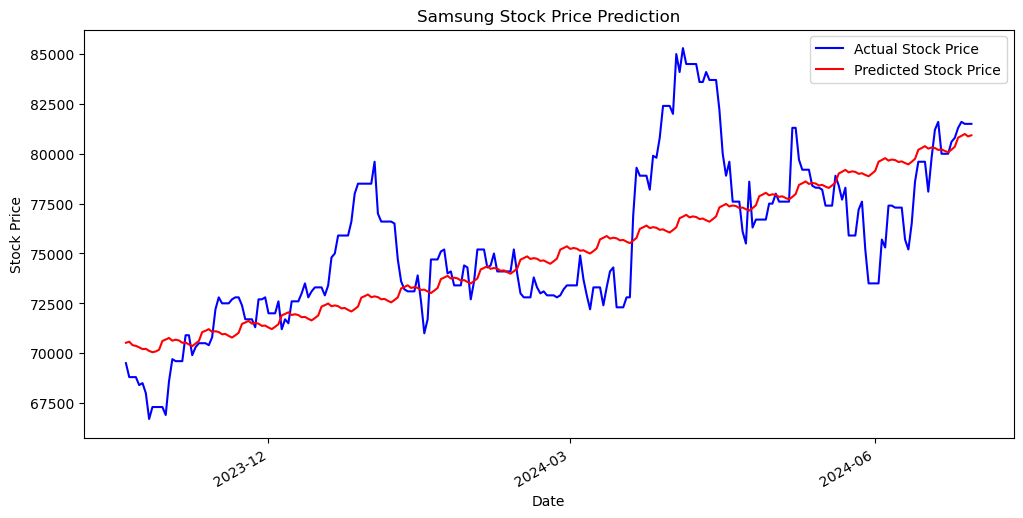

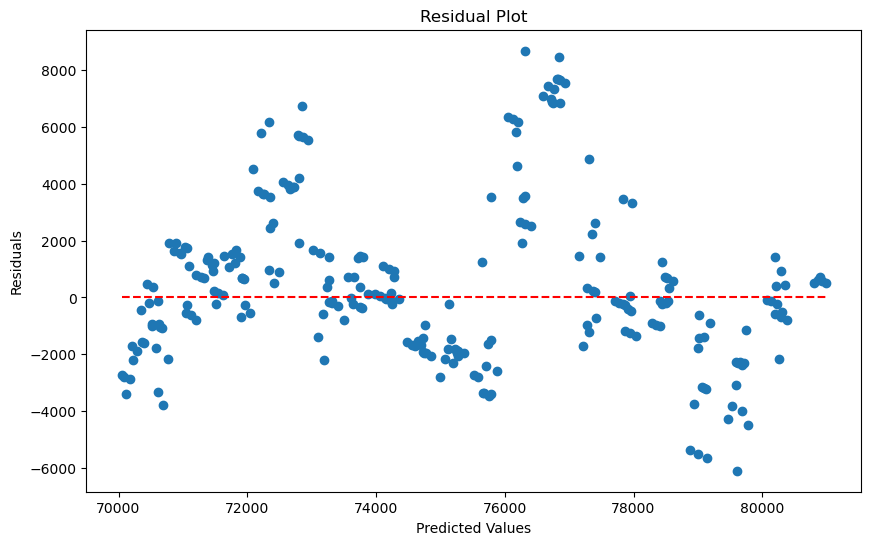

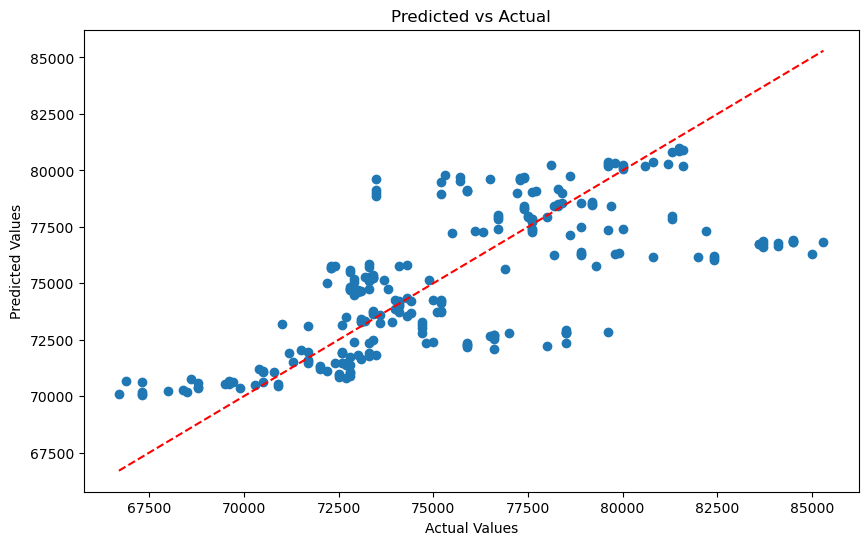

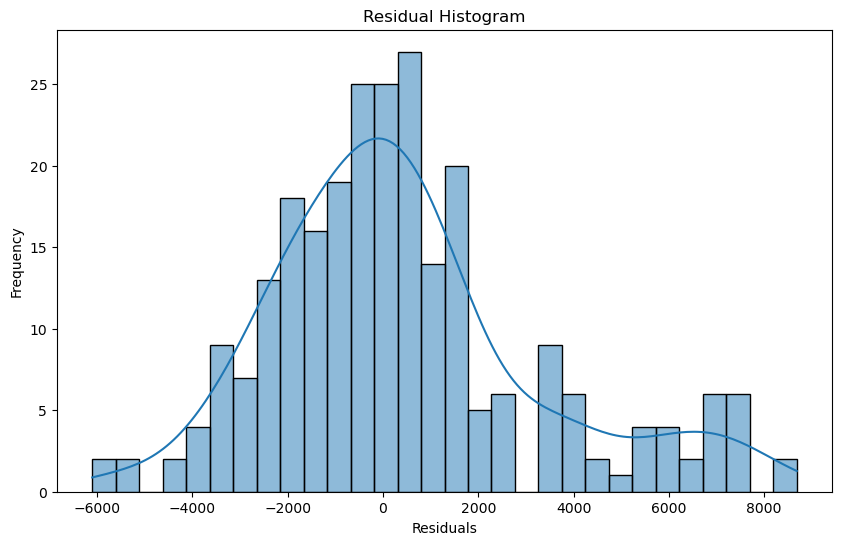

<Figure size 1000x600 with 0 Axes>

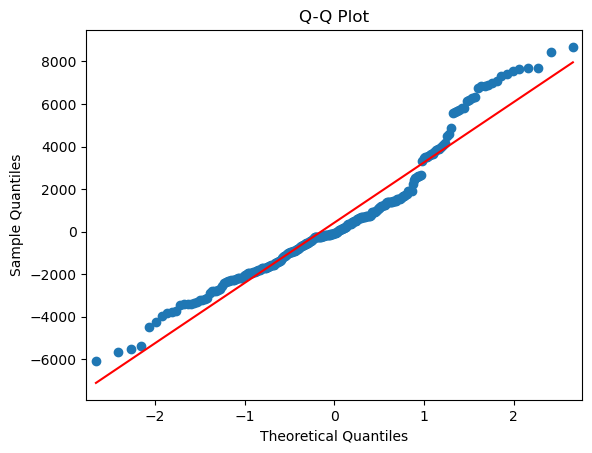

In [11]:
# 차분 복원
# 차분된 예측값을 누적합하여 원래 스케일로 복원하고, 마지막 훈련 데이터 값에 더해 원래의 시계열 값을 복원
y_pred_diff = np.cumsum(test_predictions) + df_filtered['sc_ss_stock'].iloc[train_size - 1]

# 무한대 값 또는 너무 큰 값 확인 및 처리
if np.any(~np.isfinite(y_pred_diff)) or np.any(~np.isfinite(df_filtered['sc_ss_stock'][train_size:])):
    # 예측값이나 실제 값 중에서 무한대 또는 NaN 값이 있는지 확인
    print("Warning: Infinite or NaN values found. Please check the input data and transformations.")
    # 무한대 또는 NaN 값을 가진 예측값을 제거
    y_pred_diff = y_pred_diff[np.isfinite(y_pred_diff)]
    # 무한대 또는 NaN 값을 가진 실제 값을 제거
    test_data = df_filtered['sc_ss_stock'][train_size:][np.isfinite(df_filtered['sc_ss_stock'][train_size:])]

# 유효한 예측값과 실제 값이 있는지 확인
if len(y_pred_diff) > 0 and len(df_filtered['sc_ss_stock'][train_size:]) > 0:
    # 최종 성능 지표 계산 및 출력
    mae = mean_absolute_error(df_filtered['sc_ss_stock'][train_size:], y_pred_diff)     # MAE 계산
    mse = mean_squared_error(df_filtered['sc_ss_stock'][train_size:], y_pred_diff)      # MSE 계산
    rmse = np.sqrt(mse)                                                                 # RMSE 계산
    r2 = r2_score(df_filtered['sc_ss_stock'][train_size:], y_pred_diff)                 # R² 계산

    # 성능 지표 출력
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")

    # 날짜 범위 설정 (예측 및 실제 값에 대해 동일한 날짜)
    y_test_dates = df_filtered.index[train_size:]

    # 예측 결과와 실제 값을 선 그래프로 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_dates, df_filtered['sc_ss_stock'][train_size:], color='blue', label='Actual Stock Price')
    # 실제 주식 가격을 파란색으로 플롯
    plt.plot(y_test_dates, y_pred_diff, color='red', label='Predicted Stock Price')
    # 예측된 주식 가격을 빨간색으로 플롯

    # 한 달에 하나씩 날짜 표시 (간격을 월별로 설정)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # X축 눈금 간격을 3개월로 설정
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 날짜 형식을 '년-월'로 설정
    plt.gcf().autofmt_xdate()                                           # 날짜 레이블을 자동으로 포맷팅하고 회전

    plt.title('Samsung Stock Price Prediction')                         
    plt.xlabel('Date')  
    plt.ylabel('Stock Price')  
    plt.legend()  
    plt.show()  

    # 잔차 계산
    # 실제 값과 예측 값의 차이를 계산하여 잔차(residuals)를 구함
    residuals = df_filtered['sc_ss_stock'][train_size:].values - y_pred_diff

    # 1. 잔차 플롯
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_diff, residuals)                                                             # 예측 값과 잔차를 산점도로 플롯
    plt.hlines(0, xmin=y_pred_diff.min(), xmax=y_pred_diff.max(), colors='r', linestyles='dashed')  # 잔차가 0인 선을 그음
    plt.title('Residual Plot')  
    plt.xlabel('Predicted Values')  
    plt.ylabel('Residuals')  
    plt.show()  

    # 2. 예측 vs 실제 값 플롯
    plt.figure(figsize=(10, 6))
    plt.scatter(df_filtered['sc_ss_stock'][train_size:].values, y_pred_diff)                        # 실제 값과 예측 값을 산점도로 플롯
    plt.plot([df_filtered['sc_ss_stock'][train_size:].min(), df_filtered['sc_ss_stock'][train_size:].max()], 
             [df_filtered['sc_ss_stock'][train_size:].min(), df_filtered['sc_ss_stock'][train_size:].max()], 'r--')
    # 실제 값과 예측 값의 완벽한 일치를 나타내는 대각선
    plt.title('Predicted vs Actual')  
    plt.xlabel('Actual Values') 
    plt.ylabel('Predicted Values') 
    plt.show()  # 플롯 출력

    # 3. 잔차 히스토그램
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True, bins=30)  # 잔차의 히스토그램과 커널 밀도 추정 플롯
    plt.title('Residual Histogram') 
    plt.xlabel('Residuals') 
    plt.ylabel('Frequency') 
    plt.show()  

    # 4. Q-Q 플롯
    plt.figure(figsize=(10, 6))
    sm.qqplot(residuals, line='s')              
    plt.title('Q-Q Plot')  
    plt.show() 

else:
    print("Warning: No valid predictions available for analysis.")
    # 유효한 예측이 없을 경우 경고 메시지 출력

### 모델 저장 및 불러오기

In [12]:
# 모델 저장
with open('../saved_models/Regression_Samsung_SARIMA.pkl', 'wb') as pkl_file:   # 'wb' 모드로 파일을 열어 이진 형식으로 쓰기 준비
    pickle.dump(best_model_fit, pkl_file)                                       # 학습된 SARIMA 모델 (best_model_fit)을 pkl 파일로 저장

print("Model has been saved as Regression_Samsung_SARIMA.pkl")                  # 모델이 성공적으로 저장되었음을 알림

Model has been saved as Regression_Samsung_SARIMA.pkl
